### Importing relevant packages

In [50]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
from pycaret.classification import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [51]:
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix




### Relevant functions

In [52]:
def season(x):
    if x.month < 3 or x.month==12:
        return 'summer'
    if x.month >=3 and x.month < 6:
        return 'autumn'
    if x.month >=6 and x.month < 9:
        return 'winter'
    if x.month >=9 and x.month < 12:
        return 'spring'

### Reading data

In [53]:
df_rain_aus = pd.read_csv('./data/rain_data_aus.csv')
df_wt = pd.read_csv('./data/wind_table_01.csv')

In [54]:
df_rain_aus['date'] = pd.to_datetime(df_rain_aus['date'], format='%Y-%M-%d')

### Unifying datasets

In [55]:
df_rain_aus = pd.read_csv('./data/rain_data_aus.csv')

winds_filenames = [f'./data/wind_table_0{i}.csv' for i in range(2,9)]

df_winds = pd.read_csv('./data/wind_table_01.csv')
for wind in winds_filenames:
    df_append = pd.read_csv(wind)
    zipy = {x: y for x, y in zip(df_append.columns,df_winds.columns)}
    df_winds = df_winds.append(df_append.rename(columns=zipy))

In [56]:
df_rain_aus['date'] = pd.to_datetime(df_rain_aus['date'], format='%Y-%m-%d')
df_winds['date'] = pd.to_datetime(df_winds['date'], format='%Y-%m-%d')

In [57]:
df_merged = pd.merge(left=df_rain_aus,
                    right = df_winds,
                    on = ['location', 'date'])

In [58]:
df_merged['amountOfRain'].dropna(inplace=True) #highly correlated with target variable
df_merged.drop(columns=['modelo_vigente'], inplace=True) #whats that?

In [59]:
df_merged.duplicated().sum()

22193

In [60]:
df_merged.drop_duplicates(inplace=True)

### Basic ECA

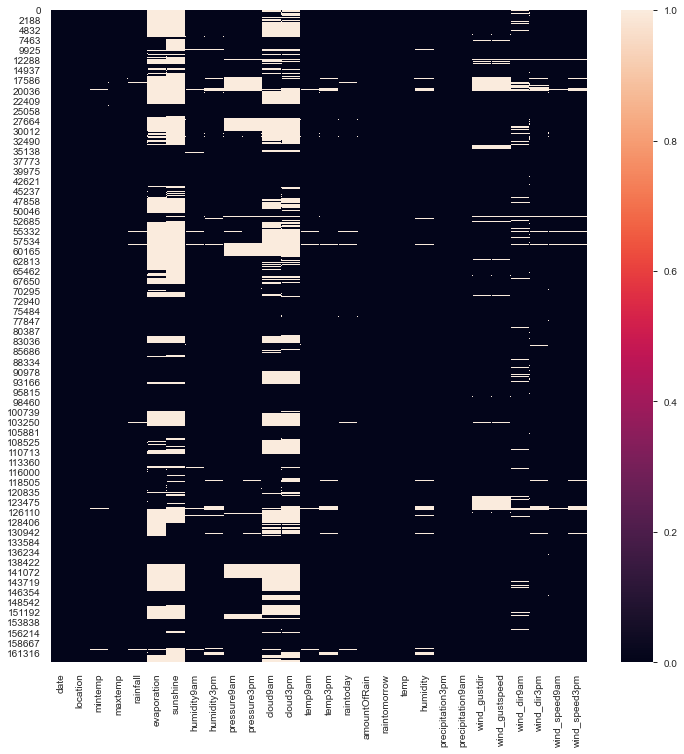

In [61]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
sns.heatmap(df_merged.isna(), ax=ax)
plt.show()

There are several features containing NaN values.
Some features seem odd, as they only contain NaN values on a fraction of the dataset and consecutively  


In [62]:
df_merged.groupby(by='location').agg({'pressure3pm':'max', 'pressure9am':'max'}).query('pressure9am!=pressure9am')

,pressure3pm,pressure9am
location,,
MountGinini,NaN,NaN
Newcastle,NaN,NaN
Penrith,NaN,NaN
SalmonGums,NaN,NaN


In [63]:
excluded_cities = list(df_merged.groupby(by='location').agg({'pressure3pm':'max', 'pressure9am':'max'}).
                       query('pressure9am!=pressure9am').index)

For the sake of simplicity, we will not be estimating weather forecast on the above cities, as 'pressure' seemed to be a critical feature on the first sprint 


In [64]:
df_merged = df_merged[~df_merged.location.isin(excluded_cities)]

### Feature Engineering

In [11]:
#Engineering based on functions
df_merged['season'] = df_merged['date'].apply(season)
df_merged['month'] = pd.DatetimeIndex(df_merged['date']).month
df_merged['firsthalf_year'] = df_merged['month'] <=6

#Engineering based on intraday shifts
df_merged['amp_temp'] = df_merged['mintemp'] /  df_merged['maxtemp']
df_merged['change_wind'] = (df_merged['wind_dir9am'] != df_merged['wind_dir3pm'])

df_merged['temp_delta'] = df_merged['temp3pm'] - df_merged['temp9am']
df_merged['hum_delta'] = df_merged['humidity3pm'] - df_merged['humidity9am']
df_merged['ws_delta'] = df_merged['wind_speed3pm'] - df_merged['wind_speed9am']
df_merged['cloud_delta'] = df_merged['cloud3pm'] - df_merged['cloud9am']
df_merged['pa_delta'] = df_merged['pressure3pm'] - df_merged['pressure9am']
df_merged['prec_delta'] = df_merged['precipitation3pm'] - df_merged['precipitation9am']

#Engineering based possible relevant variables on rain forecasting
df_merged['check_sunshine'] = (df_merged['sunshine'] == 0)
df_merged['high_sunshine'] = (df_merged['sunshine'] >= df_merged['sunshine'].median())
df_merged['LowHumidity3pm'] = (df_merged['humidity3pm'] <= df_merged['humidity3pm'].median())
df_merged['LowCloud3pm'] = (df_merged['cloud3pm'] <= df_merged['cloud3pm'].median())

#Engineering on target variable
df_merged['raintomorrow'] = df_merged['raintomorrow'].replace({'No': 0, 'Yes': 1})

#Dropping unnecessary columns
df_merged.drop(columns=['date', 'amountOfRain'], inplace=True)

### Variable distplots

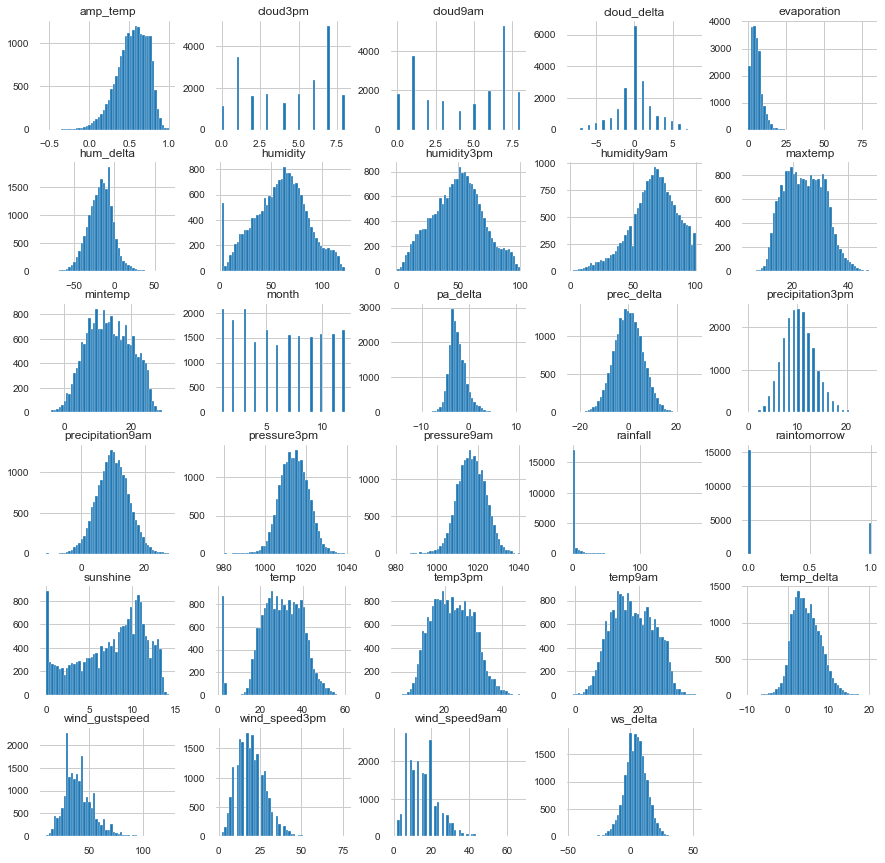

In [12]:
df_hist = df_merged.dropna().select_dtypes(exclude = ['bool','object'])
df_hist.hist(figsize = [15,15],bins = 50)
plt.show()

In [13]:
#log transformation on weird variables
df_merged['rainfall'] = df_merged['rainfall'].apply(lambda x: np.log(x) if x>0 else x)
df_merged['evaporation'] = df_merged['evaporation'].apply(lambda x: np.log(x) if x>0 else x)
df_merged['sunshine'] = df_merged['sunshine'].apply(lambda x: np.log(x) if x>0 else x)
df_merged['temp'] = df_merged['temp'].apply(lambda x: np.log(x) if x>0 else x)

In [14]:
log_features = ['rainfall', 'evaporation', 'sunshine', 'temp']
for i in log_features:
    df_merged[[i]] = QuantileTransformer(n_quantiles=100,
                                  output_distribution='normal',
                                  subsample=len(df_merged)).fit_transform(df_merged[[i]])

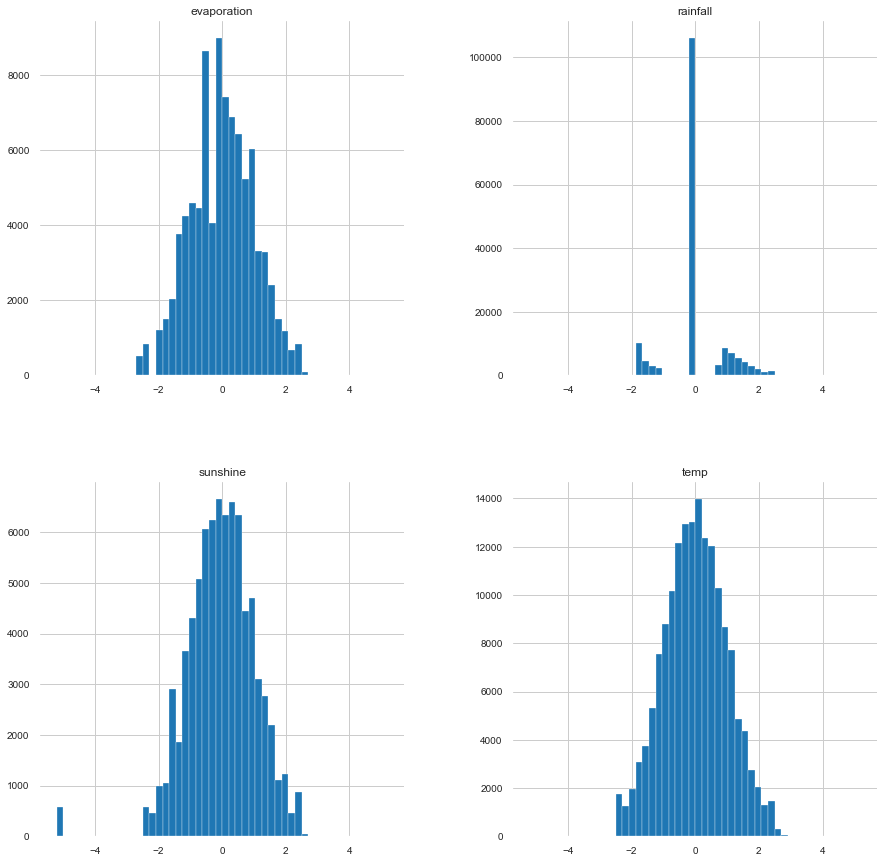

In [15]:
df_hist = df_merged[log_features]
df_hist.hist(figsize = [15,15],bins = 50)
plt.show()

In [16]:
df_merged['transformed_sunshine'] = (df_merged['sunshine'] > -4) 

### Variable transformation

In [17]:
list_cat = list(df_merged.dropna().select_dtypes(include = ['bool','object']).columns)
list_cat.extend(['raintomorrow', 'raintoday'])

In [18]:
# for each_cat in list_cat:
#     df_merged[each_cat] = df_merged[each_cat].astype('category').cat.codes

### It is time for PyCarat!

In [20]:
py_carat = setup(data = df_merged, 
                 target = 'raintomorrow', 
                 silent = True,
                 session_id=42,
                 numeric_imputation='median',
                 ignore_low_variance=True,
                 normalize=True,
                 remove_multicollinearity=True,
                 n_jobs=-1,
                 feature_selection=True,
                numeric_features = ['mintemp',
                                    'maxtemp',
                                    'rainfall',
                                    'evaporation',
                                    'sunshine',
                                    'humidity9am',
                                    'humidity3pm',
                                    'pressure9am',
                                    'pressure3pm',
                                    'cloud9am',
                                    'cloud3pm',
                                    'temp9am',
                                    'temp3pm',
                                    'temp',
                                    'humidity',
                                    'precipitation3pm',
                                    'precipitation9am',
                                    'wind_gustspeed',
                                    'wind_speed9am',
                                    'wind_speed3pm',
                                    'amp_temp',
                                    'temp_delta',
                                    'hum_delta',
                                    'ws_delta',
                                    'cloud_delta',
                                    'pa_delta',
                                    'prec_delta'],
                categorical_features = ['location',
                                        'raintoday',
                                        'wind_gustdir',
                                        'wind_dir9am',
                                        'wind_dir3pm',
                                        'season',
                                        'month',
                                        'firsthalf_year',
                                        'change_wind',
                                        'check_sunshine',
                                        'high_sunshine',
                                        'LowHumidity3pm',
                                        'LowCloud3pm',
                                        'transformed_sunshine',
                                        'check_sunshine',
                                        'high_sunshine',
                                        'LowHumidity3pm',
                                        'LowCloud3pm',
                                        'transformed_sunshine']
                )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(164386, 42)"
4,Missing Values,True
5,Numeric Features,27
6,Categorical Features,14
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [21]:
best_model = compare_models(fold=3, turbo=True, exclude=['knn', 'catboost', 'et', 'gbc'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Random Forest Classifier,0.8550,0.8639,0.4978,0.7793,0.6075,0.5238,0.5436,1.3015
1,Extreme Gradient Boosting,0.8547,0.8839,0.5392,0.7457,0.6258,0.5385,0.5495,17.3515
2,Light Gradient Boosting Machine,0.8516,0.8800,0.5189,0.7450,0.6117,0.5236,0.5367,1.6338
3,Logistic Regression,0.8399,0.8588,0.4861,0.7119,0.5777,0.4832,0.4966,1.4926
4,Ridge Classifier,0.8390,0.0000,0.4306,0.7484,0.5467,0.4573,0.4832,0.2844
5,Ada Boost Classifier,0.8384,0.8552,0.4730,0.7133,0.5688,0.4743,0.4895,12.5028
6,Linear Discriminant Analysis,0.8381,0.8554,0.4954,0.6984,0.5796,0.4829,0.4939,2.0452
7,SVM - Linear Kernel,0.8378,0.0000,0.4875,0.7023,0.5753,0.4791,0.4914,1.0162
8,Decision Tree Classifier,0.8051,0.7242,0.5768,0.5663,0.5715,0.4454,0.4454,3.4077
9,Naive Bayes,0.6691,0.7511,0.7220,0.3776,0.4958,0.2839,0.3170,0.2314


In [22]:
xgb = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8590,0.8833,0.5492,0.7587,0.6371,0.5524,0.5635
1,0.8597,0.8854,0.5515,0.7598,0.6391,0.5547,0.5657
2,0.8577,0.8916,0.5364,0.7614,0.6294,0.5446,0.5574
3,0.8517,0.8819,0.5318,0.7366,0.6177,0.5286,0.5394
4,0.8612,0.8970,0.5550,0.7646,0.6431,0.5597,0.5707
5,0.8545,0.8863,0.5341,0.7482,0.6233,0.5363,0.5480
6,0.8531,0.8859,0.5362,0.7407,0.6221,0.5338,0.5446
7,0.8572,0.8872,0.5455,0.7531,0.6327,0.5469,0.5578
8,0.8526,0.8885,0.5339,0.7399,0.6202,0.5318,0.5426
9,0.8560,0.8899,0.5297,0.7587,0.6238,0.5382,0.5515


In [23]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8667,0.8767,0.5457,0.7990,0.6485,0.5698,0.5856
1,0.8630,0.8747,0.5249,0.7982,0.6333,0.5535,0.5719
2,0.8623,0.8739,0.5199,0.7991,0.6299,0.5500,0.5691
3,0.8600,0.8697,0.5179,0.7881,0.6251,0.5435,0.5616
4,0.8670,0.8827,0.5384,0.8074,0.6460,0.5681,0.5858
5,0.8631,0.8766,0.5210,0.8023,0.6318,0.5523,0.5717
6,0.8615,0.8755,0.5162,0.7980,0.6269,0.5466,0.5661
7,0.8630,0.8728,0.5312,0.7929,0.6362,0.5559,0.5728
8,0.8601,0.8737,0.5197,0.7874,0.6261,0.5444,0.5622
9,0.8654,0.8751,0.5251,0.8112,0.6375,0.5594,0.5794


In [24]:
tuned_rf = tune_model(rf, n_iter=10,optimize='Recall') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8677,0.8881,0.5754,0.7799,0.6622,0.5823,0.5927
1,0.8649,0.8855,0.5600,0.7781,0.6513,0.5702,0.5821
2,0.8696,0.8923,0.5700,0.7933,0.6634,0.5852,0.5975
3,0.8655,0.8876,0.5681,0.7749,0.6555,0.5744,0.5851
4,0.8696,0.8978,0.5700,0.7933,0.6634,0.5852,0.5975
5,0.8688,0.8891,0.5715,0.7879,0.6625,0.5836,0.5952
6,0.8677,0.8891,0.5721,0.7827,0.6610,0.5813,0.5923
7,0.8681,0.8900,0.5752,0.7820,0.6628,0.5832,0.5938
8,0.8653,0.8905,0.5586,0.7816,0.6515,0.5709,0.5833
9,0.8669,0.8903,0.5609,0.7873,0.6551,0.5755,0.5882


In [ ]:
tuned_xgb = tune_model(xgb, n_iter=10,optimize='Recall') 

IntProgress(value=0, description='Processing: ', max=16)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:16:07
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
ETC,. . . . . . . . . . . . . . . . . .,Calculating ETC


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


In [ ]:
evaluate_model(tuned_xgb)

In [ ]:
plot_model(tuned_xgb, plot='confusion_matrix')

In [ ]:
optimize_threshold(tuned_xgb, 
                   true_negative = 1, 
                   false_negative = -5,
                   true_positive = 1,
                   false_positive = -2
                  )

In [49]:
predict_model(tuned_lgbm,probability_threshold = .36)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.853,0.879,0.6818,0.6712,0.6765,0.5814,0.5814


,mintemp,rainfall,humidity9am,humidity3pm,pressure9am,cloud9am,cloud3pm,temp9am,temp3pm,temp,...,month_8,month_9,firsthalf_year_True,high_sunshine_True,LowHumidity3pm_True,LowCloud3pm_True,transformed_sunshine_False,raintomorrow,Label,Score
0,-2.750463,-0.164053,-0.164014,0.602898,-0.006052,0.133179,0.122003,-2.756052,-2.777925,-1.621554,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.0080
1,0.146432,-1.378613,0.895567,-0.669438,0.466861,1.449322,0.122003,-0.238947,0.259982,0.339558,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.0002
2,0.475269,-0.164053,1.107483,0.015666,0.939774,-0.305536,0.122003,0.394190,-0.075940,0.179809,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.0009
3,0.146432,-0.164053,-1.117636,-1.011990,1.043224,-1.621678,-0.832568,0.363305,0.829590,0.799213,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0,1,0.8794
4,-1.106279,-0.164053,-0.058056,-0.571566,1.191009,0.133179,1.553858,-1.196373,-0.893838,-0.831366,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49311,-0.996667,-2.006250,1.637273,-0.082206,-0.345958,-1.621678,0.599288,-1.227258,-0.733180,-0.647069,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,1,0.7697
49312,0.976353,-0.164053,-3.077860,-2.235390,-0.937099,0.133179,0.122003,1.722233,2.114859,1.987235,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0.0000
49313,0.945035,-0.164053,-0.058056,0.162474,-0.006052,1.449322,0.122003,0.594941,0.026297,0.206021,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.0680
49314,-2.108448,-2.006250,1.054504,0.113538,1.324016,0.133179,0.122003,-2.107473,-1.258972,-1.189545,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.1012
